### Negative reviews

In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import fasttext
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.cluster.util import cosine_distance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import plotly.express as px

In [3]:
# Created using create_df_sentences.py
df_sentences_1_star = pd.read_csv('../data/interim/sentences_1_star.csv')
df_sentences_2_stars = pd.read_csv('../data/interim/sentences_2_stars.csv')

In [4]:
df_negative_sentences = pd.concat([df_sentences_1_star, df_sentences_2_stars])

In [7]:
tfile = open('negative.txt', 'a')
tfile.write(df_negative_sentences['text_processed'].to_string())
tfile.close()

In [8]:
model = fasttext.train_unsupervised('negative.txt')

Read 0M words
Number of words:  2890
Number of labels: 0
Progress: 100.0% words/sec/thread:   57492 lr:  0.000000 avg.loss:  2.824398 ETA:   0h 0m 0s


In [10]:
df_negative_sentences['vec'] = df_negative_sentences['text_processed'].apply(lambda x: model.get_sentence_vector(str(x)))

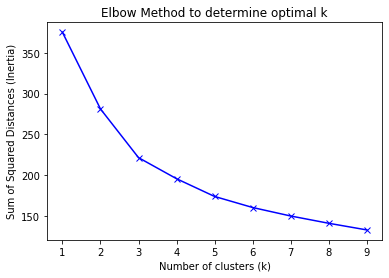

In [11]:
sum_squared_distances = []

K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df_negative_sentences['vec'].values.tolist())
    sum_squared_distances.append(kmeans.inertia_)

plt.plot(K, sum_squared_distances, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method to determine optimal k')
plt.show()

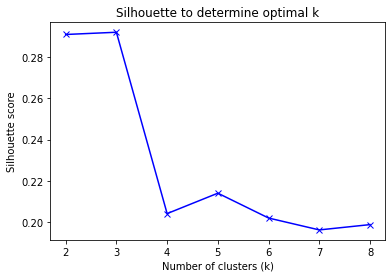

In [13]:
n_clusters_range = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []

for num_clusters in n_clusters_range:

    # fit Kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df_negative_sentences['vec'].values.tolist())
    cluster_labels = kmeans.labels_

    # calculate silhouette
    silhouette_avg.append(silhouette_score(df_negative_sentences['vec'].values.tolist(), cluster_labels))

plt.plot(n_clusters_range, silhouette_avg, 'bx-')    
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette to determine optimal k')
plt.show()

In [14]:
kmeans = KMeans(n_clusters=3)

In [15]:
df_negative_sentences['cluster'] = kmeans.fit_predict(df_negative_sentences['vec'].values.tolist())

In [17]:
cluster_0 = df_negative_sentences[df_negative_sentences['cluster']==0]
cluster_1 = df_negative_sentences[df_negative_sentences['cluster']==1]
cluster_2 = df_negative_sentences[df_negative_sentences['cluster']==2]

In [22]:
def generate_wordcloud(df):
    text = ' '.join([str(i) for i in df['text_processed']])
    wordcloud = WordCloud(max_words=100, background_color='Black').generate(text)
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

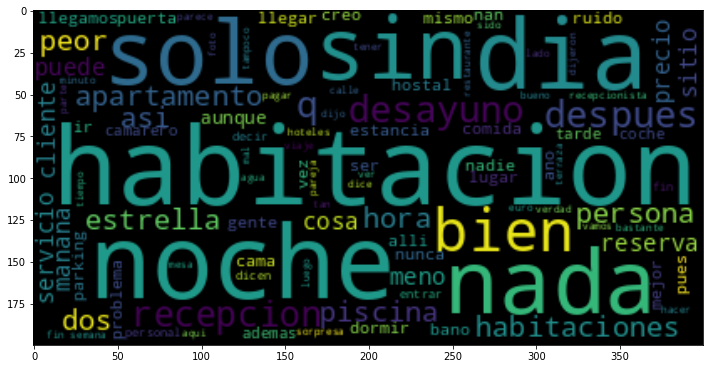

In [23]:
generate_wordcloud(cluster_0)

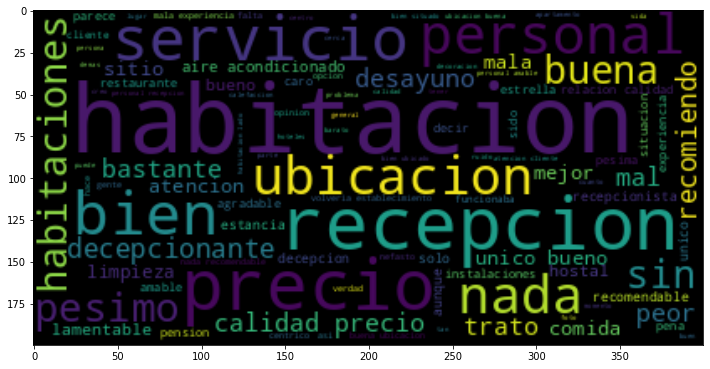

In [24]:
generate_wordcloud(cluster_1)

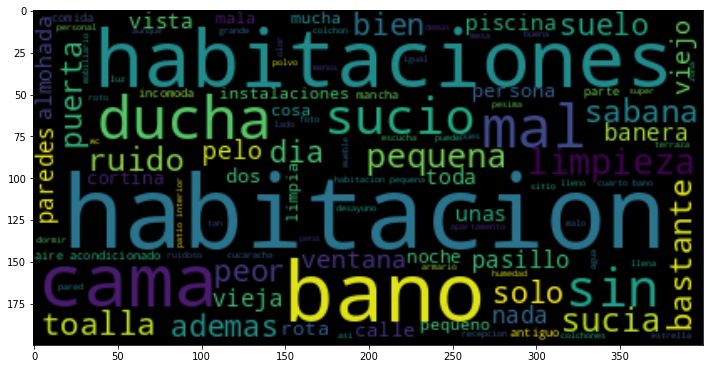

In [25]:
generate_wordcloud(cluster_2)

In [26]:
# Naming clusters
df_negative_sentences.loc[df_negative_sentences['cluster']==0, 'cluster'] = 'cat1'
df_negative_sentences.loc[df_negative_sentences['cluster']==1, 'cluster'] = 'cat2'
df_negative_sentences.loc[df_negative_sentences['cluster']==2, 'cluster'] = 'cat3'

In [27]:
# Main components to make 3D plot

pca = PCA(n_components=3)
df_negative_sentences['x'] = pca.fit_transform(df_negative_sentences['vec'].values.tolist())[:,0]
df_negative_sentences['y'] = pca.fit_transform(df_negative_sentences['vec'].values.tolist())[:,1]
df_negative_sentences['z'] = pca.fit_transform(df_negative_sentences['vec'].values.tolist())[:,2]

In [28]:
df_negative_sentences['cluster'] = df_negative_sentences['cluster'].astype('category')

In [29]:
fig = px.scatter_3d(df_negative_sentences, x='x', y='y', z='z', color='cluster')
fig.update_traces(marker_size = 2)
fig.show()

Reference:
https://towardsdatascience.com/making-sense-of-text-clustering-ca649c190b20#:~:text=For%20a%20refresh%2C%20clustering%20is,learn%20the%20pattern%20by%20itself.